In [297]:
%load_ext line_profiler


In [2]:
import numpy as np
import math as math
import random as rand
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import matplotlib as mpl
import pylab
import pandas as pd
import statsmodels.api as sm
import bindata as bnd
import matplotlib.patches as mpatches
import matplotlib

from numpy import savetxt
from scipy.stats import multivariate_normal
from tqdm import tqdm
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials



os.chdir("/Users/kyuseongchoi/Desktop/copilot_vs")


## Let's always be aware - the input index I have in mind should always deduct value 1 
# If (1, 1) is the entry of interest, then input (0, 0)

def obs_Overlap(i, j, Masking) :
    """
    Overlapped column indices both with value 1 
    """
    overlap = np.where(Masking[i, :] == Masking[j, :])[0]
    return(overlap)

def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

def gendata_Gauss(N, T, n, d, eps_N, eps_T, p, missing_pattern) : 
    """ 
    Generates Gaussian data, with latent dimension r = 2

    required : N, d are both EVEN positive integers
    """

    ## Data Matrix (N * T * n * d)
    Data = np.zeros( (N, T, n, d) )
    true_Mean = np.zeros( (N, T, d) )
    true_Cov = np.zeros( (N, T, d, d) )

    u_1 = np.random.uniform(-1, 1, N)
    u_2 = np.random.uniform(0.2, 1, N)

    v_1 = np.random.uniform(-2, 2, T)
    v_2 = np.random.uniform(0.5, 2, T)

    even_ones = np.repeat([0, 1], d/2)
    odd_ones = np.repeat([1, 0], d/2)

    for i in range(N) : 
        for t in range(T) : 
            m_it = u_1[i]*v_1[t]*(even_ones - odd_ones)
            c_it = np.diag(u_2[i]*v_2[t]*(0.5*even_ones + odd_ones))
            true_Mean[i, t, :] = m_it
            true_Cov[i, t, :, :] = c_it
            dat_mat = np.random.multivariate_normal(m_it, c_it, size = n)
            Data[i, t, :, :] = dat_mat
    
    Masking = np.zeros( (N, T) )

    ## Masking Matrix (N * T)
    zero_rows = math.floor(N**(1 - eps_N))
    zero_cols = math.floor(T**(1 - eps_T))

    # np.zeros( (zero_rows, zero_cols) )
    # np.ones( ( (N - zero_rows), zero_cols ) )
    # np.ones( ( zero_rows, (T - zero_cols) ) )
    # np.ones( ( (N - zero_rows), (T - zero_cols) ) )
    
    expit = lambda x : np.exp(x)/(1 + np.exp(x))

    if missing_pattern == "mcar" : 
        Masking = np.reshape(np.random.binomial(1, p, (N*T)), (N, T))
    if missing_pattern == "staggered" : 
        Masking = np.column_stack( (np.row_stack((np.zeros( (zero_rows, zero_cols) ), np.ones( ( (N - zero_rows), zero_cols ) ))), np.row_stack((np.ones( ( zero_rows, (T - zero_cols) ) ), np.ones( ( (N - zero_rows), (T - zero_cols) ) )))) )
    if missing_pattern == "confounded staggered" : 
        Masking = np.column_stack( (np.row_stack((np.zeros( (zero_rows, zero_cols) ), np.ones( ( (N - zero_rows), zero_cols ) ))), np.row_stack((np.ones( ( zero_rows, (T - zero_cols) ) ), np.ones( ( (N - zero_rows), (T - zero_cols) ) )))) )
    if missing_pattern == "mnar + uniform" : # Previously "mnar + non-positive"
        beta = np.repeat((-0.1, 0.2), N/2)
        Masking = np.reshape(np.random.binomial( 1, expit(sum(beta * u_1)), (N*T) ), (N, T))
    if missing_pattern == "mnar1" : # \mc U + \beta_i
        return # need to fill out
    if missing_pattern == "mnar2"  :# u_i + \beta
        Masking = np.zeros( (N, T) )
        for i in range(N) : 
            Masking[i, :] = np.random.binomial( 1, expit(sum(u_1[i] + u_2[i])), T )

    return(Data, Masking, true_Mean, true_Cov)

def gendata_rebut(N, T, n, d, eps_N, eps_T, p, missing_pattern, seed) : 
    """ 
    Generates Gaussian data, with latent dimension r = 2

    Note - N, d are both EVEN positive integers

    This is specialized to the case with added missing mechanisms 
        Unobserved confounding to full extent - up to U and V
        Conditional correlation between treatments - up to m-dependence (m = 1 or 2)
    """
    np.random.seed(seed)
    
    ## Data Matrix (N * T * n * d)
    
    Data = np.zeros( (N, T, n, d) )
    true_Mean = np.zeros( (N, T, d) )
    true_Cov = np.zeros( (N, T, d, d) )

    u_1 = np.random.uniform(-1, 1, N)
    u_2 = np.random.uniform(0.2, 1, N)

    v_1 = np.random.uniform(-2, 2, T)
    v_2 = np.random.uniform(0.5, 2, T)

    even_ones = np.repeat([0, 1], d/2)
    odd_ones = np.repeat([1, 0], d/2)

    for i in range(N) : 
        for t in range(T) : 
            m_it = u_1[i]*v_1[t]*(even_ones - odd_ones)
            c_it = np.diag(u_2[i]*v_2[t]*(0.5*even_ones + odd_ones))
            true_Mean[i, t, :] = m_it
            true_Cov[i, t, :, :] = c_it
            dat_mat = np.random.multivariate_normal(m_it, c_it, size = n)
            Data[i, t, :, :] = dat_mat


    ## Masking Matrix (N * T)

    Masking = np.zeros( (N, T) )

    zero_rows = math.floor(N**(1 - eps_N))
    zero_cols = math.floor(T**(1 - eps_T))
    
    expit = lambda x : np.exp(x)/(1 + np.exp(x))

    beta1 = np.repeat((-0.1, 0.2), N/2) # coeff of row latent factor
    beta2 = np.repeat((0.5, -0.1), T/2) # coeff of column latent factor

    if missing_pattern == "mcar" : 
        Masking = np.reshape(np.random.binomial(1, p, (N*T)), (N, T))
    if missing_pattern == "staggered" : 
        Masking = np.column_stack( (np.row_stack((np.zeros( (zero_rows, zero_cols) ), np.ones( ( (N - zero_rows), zero_cols ) ))), np.row_stack((np.ones( ( zero_rows, (T - zero_cols) ) ), np.ones( ( (N - zero_rows), (T - zero_cols) ) )))) )
    if missing_pattern == "mnar + uniform" : # Previously "mnar + non-positive"
        beta = np.repeat((-0.1, 0.2), N/2)
        Masking = np.reshape(np.random.binomial( 1, expit(sum(beta * u_1)), (N*T) ), (N, T)) 
    if missing_pattern == "mnar2"  :# u_i + \beta
        Masking = np.zeros( (N, T) )
        for i in range(N) : 
            Masking[i, :] = np.random.binomial( 1, expit((u_1[i] + u_2[i])), T )
    if missing_pattern == "mnar2 + full_confounding" : 
        Masking = np.zeros( (N, T) )
        for i in range(N) : 
            for t in range(T) : 
                Masking[i, t] = np.random.binomial( 1, expit( u_1[i] + u_2[i] + v_1[t] + v_2[t] ), 1 )
    if missing_pattern == "mnar2 + correlated" : 
        Masking = np.zeros( (N, T) )
        corr_mat = tridiag( 0.3*np.ones(T - 1), np.ones(T), 0.3*np.ones(T - 1) )
        for i in range(N) : 
            m_i = expit(u_1[i] + u_2[i])
            commonprob = bnd.bincorr2commonprob(margprob = [m_i] * T, bincorr = corr_mat)
            Masking[i, :] = bnd.rmvbin(margprob = np.diag(commonprob), commonprob = commonprob, N = 1)*1

    return(Data, Masking, true_Mean, true_Cov)

def sqmmd_est2(dat1, dat2, kernel) :
    """
    Computes U-statistics estimate of squared MMD_k, when number of samples from each distribution are different

    Input
        dat 1 : (m * d) data matrix coming from first d dim distribution
        dat 2 : (n * d) data matrix coming from second d dim distribution
        kernel : k(x, y) that defines MMD_k^2
    
    Output
        MMD_k^2 estimator
    """
    m = dat1.shape[0]
    n = dat2.shape[0]

    if dat1.shape[1] != dat2.shape[1] : 
        print("Data dimension do not match!")
        return
    
    d = dat1.shape[1]

    XX = np.matmul(dat1, np.transpose(dat1)) # m by m matrix with x_i^Tx_j
    YY = np.matmul(dat2, np.transpose(dat2)) # n by n matrix with y_i^Ty_j
    XY = np.matmul(dat1, np.transpose(dat2)) # m by n matrix with x_i^Ty_j  

    if kernel == "linear" :
        kXX, kYY, kXY = XX, YY, XY
    if kernel == "square" :
        kXX, kYY, kXY = (XX + np.ones( (m, m) ))**2, (YY + np.ones( (n, n) ))**2, (XY + np.ones( (m, n) ))**2
    if kernel == "exponential" :
        dXX_mm = np.vstack((np.diag(XX), )*m)
        dYY_nn = np.vstack((np.diag(YY), )*n)
        dXX_mn = np.hstack((np.diag(XX), )*n)
        dYY_mn = np.vstack((np.diag(YY), )*m)

        kXX = math.exp( -0.5*( dXX_mm + np.transpose(dXX_mm) - 2*XX ) ) 
        kYY = math.exp( -0.5*( dYY_nn + np.transpose(dYY_nn) - 2*YY ) )
        kXY = math.exp( -0.5*( dXX_mn + dYY_mn - 2*XY ) )
        
    val = (kXX.sum() - np.diag(kXX).sum())/(m*(m - 1)) + (kYY.sum() - np.diag(kYY).sum())/(n*(n - 1)) - 2*kXY.sum()/(n*m)
    if val < 0 : 
        val = 0

    return(val)

def row_Metric(i, j, t, Data, Masking, kernel, exc_opt) : 
    """
    Computes MMD_k^2 based metric between rows of Distributional Matrix~(DM) with missingness

    Input
        i, j : two row indices under comparison
        t : column of interest - so need to exclude this column
        kernel : baseline kernel
        Data : (N * T * n * d) array 
        Masking : (N * T) sized matrix indicating which entries are observed(val = 1)
        exc_opt : if True, omit t th column when constructing row metric, if False, include t th column
    Output
        Metric between row i, j when the target parameter is on the t th column
    """

    N = Masking.shape[0]
    T = Masking.shape[1]
    
    overlap = obs_Overlap(i, j, Masking)

    if exc_opt == True : 
        if sum(np.isin(overlap, t)) == 1 : 
            overlap = np.delete(overlap, np.where(overlap == t)[0])
    if len(overlap) == 0 : 
        val = 10**5
        return(val)

    Data_i = Data[i, :, :, :]
    Data_j = Data[j, :, :, :]

    pre_val = np.zeros(len(overlap))
    for tau in range(len(overlap)) :
        tau_ind = overlap[tau]
        pre_val[tau] = sqmmd_est2(Data_i[tau_ind, :, :], Data_j[tau_ind, :, :], kernel)
    
    val = sum(pre_val)/len(overlap)

    return(val)

def row_mmDNN(i, t, Data, row_Dissim_vec, Masking, eta) : 
    """
    Implements DNN with MMD_k^2 to impute (i, t) entry using eta radius

    t th column of Data is used for averaging
    t th column of Masking is used to pick the ones observed ... (1)
    row_Dissim_vec, eta are used to pick the ones within neighborhood ... (2)
    when intersecting (1) and (2), make sure to exclude i th row and then take the barycenter
    
    note kernel information is already used when constructing row_Dissim_vec from another function 

    Input
        i, t : index of target distribution - mu_{i, t}
        row_Dissim_vec : row-wise metric (rho_{i, j}) for j in [N], excluding t th column for construction
        Data : (N * T * n * d) array
        Masking : (N * T) array
        kernel : baseline kernel
        eta : radius
    Output
        (|neighbor| * n * d) sized array of all the neighboring measurements
    """
    N, T, n, d = Data.shape[0], Data.shape[1], Data.shape[2], Data.shape[3]

    neighbor_candidate = Data[:, t, :, :]

    neighbor_ind = np.where( (row_Dissim_vec < eta)*(Masking[:, t]) == 1 )[0]

    if sum(np.isin(neighbor_ind, i)) == 1 : # Pretending as IF (i, t) entry is missing
        neighbor_ind = np.delete(neighbor_ind, np.where(neighbor_ind == i)[0])

    if len(neighbor_ind) == 0 :
        neighbor = np.zeros( (n, d) )
        return(neighbor)

    neighbor = neighbor_candidate[neighbor_ind, :, :]

    neighbor = neighbor.reshape(-1, neighbor.shape[-1]) # ((|neighbor_ind| x n) * d) array

    return(neighbor)

    # if len(neighbor_ind) == 1 :
    #     return(neighbor) # (n * d) array
    # if len(neighbor_ind) > 1 :
    #     neighbor = neighbor.reshape(-1, neighbor.shape[-1]) # ((|neighbor_ind| x n) * d) array
    #     return(neighbor)

def mmDNN_cv(Data, Masking, kernel, eta_cand) : 
    """
    Among eta_cand, chooses the optimal radius eta that minimizes 2-fold CV error

    Input 
        Data : Full data that is split into two - train & test
        Masking : Full Masking matrix that is split into two - train & test
        eta_cand : Candidate of radius that is explored

    Output
        Optimal radius eta^star
    """
    N, T, n, d = Data.shape[0], Data.shape[1], Data.shape[2], Data.shape[3]

    if (T % 2) == 0 : 
        T_1 = int(T/2)
    if (T % 2) == 1 :
        T_1 = int((T + 1)/2)

    Data1 = Data[:, np.arange(T_1), :, :]
    Masking1 = Masking[:, np.arange(T_1)]

    Data2 = Data[:, np.arange(T_1, T), :, :]
    Masking2 = Masking[:, np.arange(T_1, T)]


    # Construct rho_{i, j} for rows using Data 1 ... (1)
    row_Dissim_mat = np.zeros( (N, N) )

    t_0 = 1 # Arbitrary column index when constructing rho_{i, j} under CV process
    for i in range(N - 1) :
        for j in range((i + 1), N) :
            row_Dissim_mat[i, j] = row_Metric(i, j, t_0, Data1, Masking1, kernel, exc_opt = False)
    
    row_Dissim_mat = row_Dissim_mat + np.transpose(row_Dissim_mat)
    
    # Estimate `observed` entries in Data 2 using rho_{i, j} in (1) ... (2)
    T_2 = T - T_1 # Length of second partition of Data

    perf = np.zeros(len(eta_cand))
    for eta_ind in range( len(eta_cand) ) :
        eta = eta_cand[eta_ind]
        mmd_error = np.zeros( (N, T_2) )
        for i in range(N) : 
            for t in range(T_2) :
                if Masking2[i, t] == 1 :
                    hat_mu_it = row_mmDNN(i, t, Data2, row_Dissim_mat[i, :], Masking2, eta)
                    mmd_error_it = sqmmd_est2(hat_mu_it, Data2[i, t, :, :], kernel)
                    mmd_error[i, t] = mmd_error_it
        perf[eta_ind] = mmd_error.sum()/(Masking2.sum())

    eta_star = eta_cand[np.argmin(perf)]
    
    return(eta_star)


## New functions for using "automated" cross validation --- T = 60, K = 3

def row_Metric_cv(Data, Masking, kernel, K) : 
    """
    Outputs K number of (N * N) row-metric matrices 
        Data/Masking is partitioned(column-wise) into K submatrices
        Discard one submatrix and compute row-wise metric using the remaining submatrices
        Save it into a list - this will be the input of Cross Validation
    """
    
def mmDNN_cv2(Data, Masking, kernel, eta, K_fold) : 
    # This is the CV function to be applied for adaptive cross validation
    """
    Among eta_cand, chooses the optimal radius eta that minimizes 2-fold CV error

    Input 
        Data : Full data that is split into two - train & test
        Masking : Full Masking matrix that is split into two - train & test
        eta_cand : Candidate of radius that is explored
        K_fold : number of folds considered
    Output
        Optimal radius eta^star
    """
    N, T, n, d = Data.shape[0], Data.shape[1], Data.shape[2], Data.shape[3]

    ## CV requires partitioning data set - how to partition when missing pattern is L shaped? 

    if (T % 2) == 0 : 
        T_1 = int(T/2)
    if (T % 2) == 1 :
        T_1 = int((T + 1)/2)

    Data1 = Data[:, np.arange(T_1), :, :]
    Masking1 = Masking[:, np.arange(T_1)]

    Data2 = Data[:, np.arange(T_1, T), :, :]
    Masking2 = Masking[:, np.arange(T_1, T)]


    # Construct rho_{i, j} for rows using Data 1 ... (1)
    row_Dissim_mat = np.zeros( (N, N) )

    t_0 = 1 # Arbitrary column index when constructing rho_{i, j} under CV process
    for i in range(N - 1) :
        for j in range((i + 1), N) :
            row_Dissim_mat[i, j] = row_Metric(i, j, t_0, Data1, Masking1, kernel, exc_opt = False)
    
    row_Dissim_mat = row_Dissim_mat + np.transpose(row_Dissim_mat)
    
    # Estimate `observed` entries in Data 2 using rho_{i, j} in (1) ... (2)
    T_2 = T - T_1 # Length of second partition of Data

    perf = np.zeros(len(eta_cand))
    for eta_ind in range( len(eta_cand) ) :
        eta = eta_cand[eta_ind]
        mmd_error = np.zeros( (N, T_2) )
        for i in range(N) : 
            for t in range(T_2) :
                if Masking2[i, t] == 1 :
                    hat_mu_it = row_mmDNN(i, t, Data2, row_Dissim_mat[i, :], Masking2, eta)
                    mmd_error_it = sqmmd_est2(hat_mu_it, Data2[i, t, :, :], kernel)
                    mmd_error[i, t] = mmd_error_it
        perf[eta_ind] = mmd_error.sum()/(Masking2.sum())

    eta_star = eta_cand[np.argmin(perf)]
    
    return(eta_star)

In [3]:
fix_plot_settings = True
if fix_plot_settings:
    plt.rc('font', family='serif')
    plt.rc('text', usetex=False)
    label_size = 20
    mpl.rcParams['xtick.labelsize'] = label_size 
    mpl.rcParams['ytick.labelsize'] = label_size 
    mpl.rcParams['axes.labelsize'] = label_size
    mpl.rcParams['axes.titlesize'] = label_size
    mpl.rcParams['figure.titlesize'] = label_size
    mpl.rcParams['lines.markersize'] = label_size
    mpl.rcParams['grid.linewidth'] = 2.5
    mpl.rcParams['legend.fontsize'] = label_size
    pylab.rcParams['xtick.major.pad']=5
    pylab.rcParams['ytick.major.pad']=5

    lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
    mss = ['>', 'o',  's', 'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
    ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
    colors = ['#e41a1c', '#0000cd', '#4daf4a',  'black' , 'magenta']
else:
    pass

/var/folders/ng/1zd7d3bs0p79qr4lw85bcbxh0000gn/T/ipykernel_32931/1157374914.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Masking[i, t] = np.random.binomial( 1, expit( u_1[i] + u_2[i] + v_1[t] + v_2[t] ), 1 )


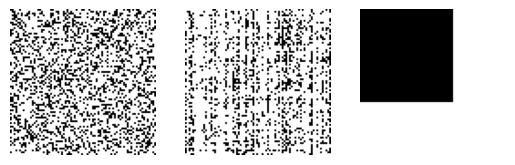

In [4]:
## Graphical representation of missingness

N, T, n, d = 80, 80, 30, 2
eps_N, eps_T = 0.1, 0.1
p = 0.7
i, t = 0, 0

sim = 30

missing_collection = [ "mcar", "staggered", "mnar + uniform", "mnar2", "mnar2 + full_confounding", "mnar2 + correlated" ]

Data, Masking1, true_Mean, true_Cov = gendata_rebut(N, T, n, d, eps_N, eps_T, p, missing_pattern = "mcar", seed = sim)
Data, Masking2, true_Mean, true_Cov = gendata_rebut(N, T, n, d, eps_N, eps_T, p, missing_pattern = "mnar2 + full_confounding", seed = sim)
Data, Masking3, true_Mean, true_Cov = gendata_rebut(N, T, n, d, eps_N, eps_T, p, missing_pattern = "staggered", seed = sim)

# im = plt.imshow(Masking, aspect = 'auto')
# plt.ylabel("Units")
# plt.xlabel("Outcomes")
# plt.gca().xaxis.tick_bottom()

# values = [0, 1]
# colors = [ im.cmap((value)) for value in values]
# print(im.cmap(im.norm(0)))
# print(colors)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(Masking1, cmap='gray')
ax[0].axis('off')
ax[1].imshow(Masking2, cmap='gray')
ax[1].axis('off')
ax[2].imshow(Masking3, cmap='gray')
ax[2].axis('off')

plt.show()

#create a patch (proxy artist) for every color 
# patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
#put those patched as legend-handles into the legend
# plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc=6, borderaxespad=0.)

# fig = plt.gcf()
# fig.set_size_inches(4, 4)

# plt.title("Treatment assignment pattern")

In [ ]:
# Test Run of Simulation

N, T, n, d = 20, 20, 100, 4
eps_N, eps_T = 0.3, 0.3
p = 0.7
kernel = "square"
eta_pool = np.arange(1, 25)/5
missing_pattern = "mnar + non-positive"
i, t = 0, 0

nsim = 5
perf_pool, eta_star_pool = np.zeros( nsim ), np.zeros( nsim )

for sim in tqdm(range(nsim)) :
    Data, Masking, true_Mean, true_Cov = gendata0(N, T, n, d, eps_N, eps_T, p, missing_pattern)
    true_Mean_it = true_Mean[i, t, :]
    true_Cov_it = true_Cov[i, t, :, :]

    row_Dissim_vec = np.zeros(N)

    for j in tqdm(range(N)) :
        row_Dissim_vec[j] = row_Metric(i, j, t, Data, Masking, kernel, exc_opt = True)

    eta_star = mmDNN_cv(Data, Masking, kernel, eta_cand = eta_pool)
    eta_star_pool[sim] = eta_star

    hat_mu_it = row_mmDNN(i, t, Data, row_Dissim_vec, Masking, eta = eta_star)
    samples_from_truth = np.random.multivariate_normal( true_Mean_it, true_Cov_it, size = (N*n) )
    perf_pool[sim] = sqmmd_est2( hat_mu_it, samples_from_truth, kernel )

print(perf_pool)
print(eta_star_pool)


In [108]:
Data, masking, true_mean, true_Cov = gendata_rebut(N = 10, T = 16, n = 10, d = 2, eps_N = 0.3, eps_T = 0.3, p = 0.7, missing_pattern = "mnar2 + correlated", seed = 1)
print(masking)

[[1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.]]


In [30]:
###############################################
# Simulation by "N" + "MNAR + non-positivity" #
###############################################

T, n, d = 60, 60, 4
eps_N, eps_T = 0.3, 0.3
p = 0.5
kernel = "square"
# eta_pool = np.arange(1, 30, 0.5)/3 # used for MNAR + non-positive
eta_pool = np.append(np.arange(0, 3, 0.2), np.arange(3, 6, 0.4)) # used for MCAR
missing_pattern = "mcar" # Essentially Staggered Adoption + Unobserved Confounding
i, t = 0, 0

nsim = 30

pools = []
pools_eta = []
# print(f"{0}-th iteration")
for i, row_exp in enumerate(np.arange(4, 8)): 
    print(f"{i}-th iteration")
    # print("row size", row_exp)
    N = 2**(row_exp)
    perf_pool, eta_star_pool = np.zeros( nsim ), np.zeros( nsim )

    for sim in tqdm(range(nsim)) :
        
        Data, Masking, true_Mean, true_Cov = gendata0(N, T, n, d, eps_N, eps_T, p, missing_pattern)
        true_Mean_it = true_Mean[i, t, :]
        true_Cov_it = true_Cov[i, t, :, :]

        row_Dissim_vec = np.zeros(N)

        for j in range(N) :

            row_Dissim_vec[j] = row_Metric(i, j, t, Data, Masking, kernel, exc_opt = True)

        eta_star = mmDNN_cv(Data, Masking, kernel, eta_cand = eta_pool)
        eta_star_pool[sim] = eta_star

        hat_mu_it = row_mmDNN(i, t, Data, row_Dissim_vec, Masking, eta = eta_star)
        samples_from_truth = np.random.multivariate_normal( true_Mean_it, true_Cov_it, size = (N*n) )
        perf_pool[sim] = sqmmd_est2( hat_mu_it, samples_from_truth, kernel )
    pools_eta.append(eta_star_pool)
    pools.append(perf_pool)

with open("results/N_mcar_p05_T60.pkl", "wb") as f:
    pickle.dump(pools, f)

with open("results/N_mcar_p05_T60_eta.pkl", "wb") as f:
    pickle.dump(pools_eta, f)
    

0-th iteration


100%|██████████| 30/30 [01:17<00:00,  2.57s/it]


1-th iteration


100%|██████████| 30/30 [03:51<00:00,  7.71s/it]


2-th iteration


100%|██████████| 30/30 [20:11<00:00, 40.38s/it]


3-th iteration


100%|██████████| 30/30 [2:00:00<00:00, 240.02s/it]  


[7.36527678 0.84506118 0.59501492 0.35738488]
[4.69333333 4.83333333 3.81333333 2.28      ]
[ 5.48174273  3.35437054  1.22699834 -0.90037385]
-2.127372195420561


TypeError: list.append() takes exactly one argument (2 given)

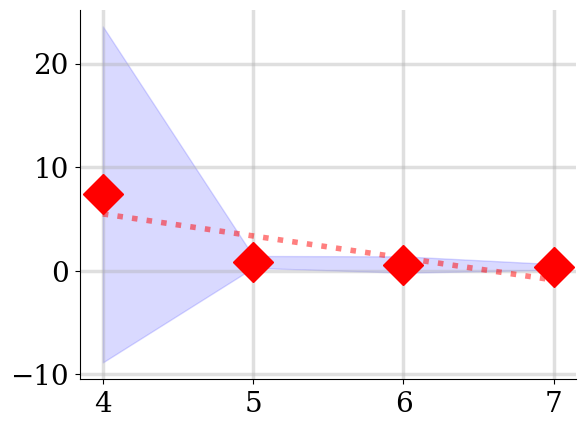

In [65]:
with open("results/arXiv/N_mcar_p05_T60.pkl", "rb") as f:
    N_mcar_p05_T60 = pickle.load(f)

with open("results/arXiv/N_mcar_p05_T60_eta.pkl", "rb") as f:
    N_mcar_p05_T60_eta = pickle.load(f)

center_mcar = np.zeros(4)
sd_mcar = np.zeros(4)

for i in range(4) : 
    center_mcar[i] = np.mean( N_mcar_p05_T60[i] )
    sd_mcar[i] = np.std( N_mcar_p05_T60[i] )

ci_length = 1.96 * sd_mcar / np.sqrt(10)
ci_upper = center_mcar + ci_length
ci_lower = center_mcar - ci_length

center_eta_mcar = np.zeros(4)
sd_eta_mcar = np.zeros(4)

for i in range(4) : 
    center_eta_mcar[i] = np.mean( N_mcar_p05_T60_eta[i] )
    sd_eta_mcar[i] = np.std( N_mcar_p05_T60_eta[i] )

ci_eta_length = 1.96 * sd_eta_mcar / np.sqrt(10)
ci_eta_upper = center_eta_mcar + ci_length
ci_eta_lower = center_eta_mcar - ci_length


print(center_mcar)
log_N = np.arange(4, 8)

df_eta_mcar = np.column_stack( (log_N, center_eta_mcar, ci_eta_upper, ci_eta_lower) )
df_mcar = np.column_stack( (log_N, center_mcar, ci_upper, ci_lower) )

df_mcar = pd.DataFrame(df_mcar, columns= ["Log row size", "mean", "upper 95", "lower 95"] )

fig, ax = plt.subplots()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)

x = df_mcar["Log row size"]
l1, = ax.plot(x, df_mcar["mean"], marker=mss[3], color = "red", linestyle='None')
ax.fill_between(x, df_mcar["lower 95"], df_mcar["upper 95"], color='b', alpha=.15)

print(center_eta_mcar)

design = np.column_stack((np.ones(4), log_N))

model = sm.OLS(center_mcar, design).fit()
print(model.predict())
print(model.params[1])

l2, = ax.plot(x, (model.predict()), linestyle=lss[1], linewidth=4, color = "red", alpha=.5)
ls = []
labs = []

ls.append(l1, l2)

# ax.set_ylim(ymin=0)
# ax.set_title()
# fig.autofmt_xdate(rotation=45)

[4 5 6 7]
[0.96023954 0.7618669  0.5230668  0.32371271]
[0.96447857 0.74964051 0.53480246 0.3199644 ]
-0.21483805658012967


TypeError: list.append() takes exactly one argument (2 given)

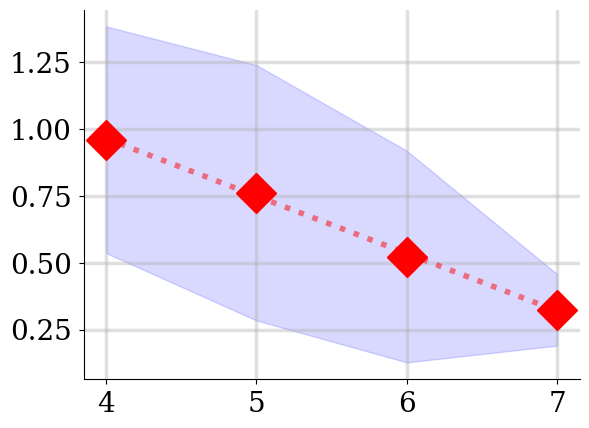

In [13]:
with open("results/arXiv/N_mnar_nonpositive_T60.pkl", "rb") as f:
    N_mnar_positive_T60 = pickle.load(f)

with open("results/arXiv/N_mnar_nonpositive_T60_eta.pkl", "rb") as f:
    N_mnar_positive_T60_eta = pickle.load(f)

center_staggered_confound = np.zeros(4)
sd_staggered_confound = np.zeros(4)

for i in range(4) : 
    center_staggered_confound[i] = np.mean( N_mnar_positive_T60[i] )
    sd_staggered_confound[i] = np.std( N_mnar_positive_T60[i] )

ci_length = 1.96 * sd_staggered_confound / np.sqrt(30)
ci_upper = center_staggered_confound + ci_length
ci_lower = center_staggered_confound - ci_length

# center_eta_staggered_confound = np.zeros(4)
# sd_eta_staggered_confound = np.zeros(4)

# for i in range(4) : 
#     center_eta_staggered_confound[i] = np.mean( N_mnar_positive_T60_eta[i] )
#     sd_eta_staggered_confound[i] = np.std( N_mnar_positive_T60_eta[i] )

# ci_eta_length = 1.96 * sd_eta_staggered_confound / np.sqrt(30)
# ci_eta_upper = center_eta_staggered_confound + ci_length
# ci_eta_lower = center_eta_staggered_confound - ci_length



log_N = np.arange(4, 8)

# df_eta_staggered_confound = np.column_stack( (log_N, center_eta_staggered_confound, ci_eta_upper, ci_eta_lower) )

df_staggered_confound = np.column_stack( (log_N, center_staggered_confound, ci_upper, ci_lower) )

# print(df_staggered_confound)
# print(center_staggered_confound)
# print(ci_upper)
# print(ci_lower)

# pd.option_context('mode.use_inf_as_na', True)

df_staggered_confound = pd.DataFrame(df_staggered_confound, columns= ["Log row size", "mean", "upper 95", "lower 95"] )

fig, ax = plt.subplots()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)

x = df_staggered_confound["Log row size"]
l1, = ax.plot(x, df_staggered_confound["mean"], marker=mss[3], color = "red", linestyle='None')
ax.fill_between(x, df_staggered_confound["lower 95"], df_staggered_confound["upper 95"], color='b', alpha=.15)

print(log_N)
print(center_staggered_confound)

design = np.column_stack((np.ones(4), log_N))

model = sm.OLS(center_staggered_confound, design).fit()
print(model.predict())

l2, = ax.plot(x, (model.predict()), linestyle=lss[1], linewidth=4, color = "red", alpha=.5)
ls = []
labs = []

print(model.params[1])
ls.append(l1, l2)

# ax.set_ylim(ymin=0)
# ax.set_title()
# fig.autofmt_xdate(rotation=45)

In [116]:
########################################
##### Simulations for the Rebuttal #####
########################################

T, n, d = 80, 30, 2
eps_N, eps_T = 0.3, 0.3
kernel = "square"
# eta_pool = np.arange(1, 30, 0.5)/3
eta_pool = np.append(np.arange(0, 3, 0.2), np.arange(3, 6, 0.4))
i, t = 0, 0

nsim = 30

missing_collection = [ "mcar", "staggered", "mnar + uniform", "mnar2", "mnar2 + full_confounding", "mnar2 + correlated" ]

for missing_pattern in missing_collection : 

    pools = []
    pools_eta = []
    
    for i, row_exp in enumerate(np.arange(4, 8)): 

        print(f"{i}-th iteration")
        # print("row size", row_exp)
        N = 2**(row_exp)
        perf_pool, eta_star_pool = np.zeros( nsim ), np.zeros( nsim )

        for sim in tqdm(range(nsim)) :
            
            Data, Masking, true_Mean, true_Cov = gendata_rebut(N, T, n, d, eps_N, eps_T, p, missing_pattern, seed = sim)
            true_Mean_it = true_Mean[i, t, :]
            true_Cov_it = true_Cov[i, t, :, :]

            row_Dissim_vec = np.zeros(N)

            for j in range(N) :

                row_Dissim_vec[j] = row_Metric(i, j, t, Data, Masking, kernel, exc_opt = True)

            eta_star = mmDNN_cv(Data, Masking, kernel, eta_cand = eta_pool)
            eta_star_pool[sim] = eta_star

            hat_mu_it = row_mmDNN(i, t, Data, row_Dissim_vec, Masking, eta = eta_star)
            samples_from_truth = np.random.multivariate_normal( true_Mean_it, true_Cov_it, size = (N*n) )
            perf_pool[sim] = sqmmd_est2( hat_mu_it, samples_from_truth, kernel )

        pools_eta.append(eta_star_pool)
        pools.append(perf_pool)

    with open("results/rebuttal" + missing_pattern + ".pkl", "wb") as f:
        pickle.dump(pools, f)

    with open("results/rebuttal" + missing_pattern + "_eta.pkl", "wb") as f:
        pickle.dump(pools_eta, f)
    

0-th iteration


100%|██████████| 30/30 [01:00<00:00,  2.03s/it]


1-th iteration


100%|██████████| 30/30 [03:46<00:00,  7.55s/it]


2-th iteration


100%|██████████| 30/30 [14:26<00:00, 28.89s/it]


3-th iteration


100%|██████████| 30/30 [1:32:07<00:00, 184.24s/it]


0-th iteration


100%|██████████| 30/30 [02:33<00:00,  5.12s/it]


1-th iteration


100%|██████████| 30/30 [12:56<00:00, 25.89s/it]


2-th iteration


100%|██████████| 30/30 [1:22:16<00:00, 164.56s/it]


3-th iteration


 17%|█▋        | 5/30 [2:31:30<12:37:33, 1818.12s/it]


KeyboardInterrupt: 

[2.61333333 2.38       1.54666667 1.56      ]
[2.61333333 2.38       1.54666667 1.56      ]


TypeError: list.append() takes exactly one argument (2 given)

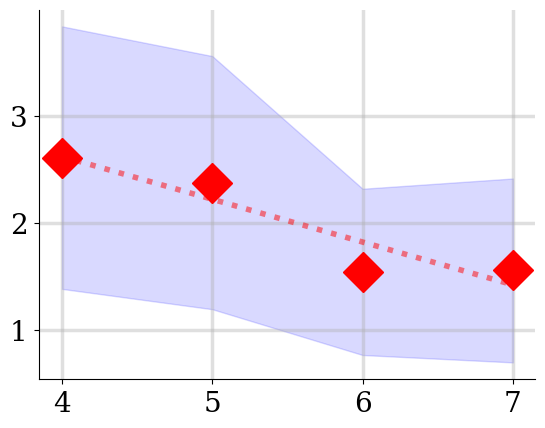

In [60]:
with open("results/rebuttal_full_confound.pkl", "rb") as f:
    N_mcar_p05_T60 = pickle.load(f)

with open("results/rebuttal_full_confound.pkl", "rb") as f:
    N_mcar_p05_T60_eta = pickle.load(f)

center_mcar = np.zeros(4)
sd_mcar = np.zeros(4)

for i in range(4) : 
    center_mcar[i] = np.mean( N_mcar_p05_T60[i] )
    sd_mcar[i] = np.std( N_mcar_p05_T60[i] )

ci_length = 1.96 * sd_mcar / np.sqrt(10)
ci_upper = center_mcar + ci_length
ci_lower = center_mcar - ci_length

center_eta_mcar = np.zeros(4)
sd_eta_mcar = np.zeros(4)

for i in range(4) : 
    center_eta_mcar[i] = np.mean( N_mcar_p05_T60_eta[i] )
    sd_eta_mcar[i] = np.std( N_mcar_p05_T60_eta[i] )

ci_eta_length = 1.96 * sd_eta_mcar / np.sqrt(10)
ci_eta_upper = center_eta_mcar + ci_length
ci_eta_lower = center_eta_mcar - ci_length


print(center_mcar)
log_N = np.arange(4, 8)

df_eta_mcar = np.column_stack( (log_N, center_eta_mcar, ci_eta_upper, ci_eta_lower) )
df_mcar = np.column_stack( (log_N, center_mcar, ci_upper, ci_lower) )

df_mcar = pd.DataFrame(df_mcar, columns= ["Log row size", "mean", "upper 95", "lower 95"] )

fig, ax = plt.subplots()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)

x = df_mcar["Log row size"]
l1, = ax.plot(x, df_mcar["mean"], marker=mss[3], color = "red", linestyle='None')
ax.fill_between(x, df_mcar["lower 95"], df_mcar["upper 95"], color='b', alpha=.15)

print(center_eta_mcar)

design = np.column_stack((np.ones(4), log_N))

model = sm.OLS(center_mcar, design).fit()
# print(model.predict())

l2, = ax.plot(x, (model.predict()), linestyle=lss[1], linewidth=4, color = "red", alpha=.5)
ls = []
labs = []

ls.append(l1, l2)

# ax.set_ylim(ymin=0)
# ax.set_title()
# fig.autofmt_xdate(rotation=45)

In [ ]:
# Simulation by "N" + "MCAR + Non-positivity"

T, n, d = 20, 100, 4
eps_N, eps_T = 0.3, 0.3
p = 0.7
kernel = "square"
eta_pool = np.arange(1, 25)/5
missing_pattern = "mcar"
i, t = 0, 0

nsim = 30

pools = []
# print(f"{0}-th iteration")
for i, row_exp in enumerate(np.arange(2, 7)): 
    print(f"{i}-th iteration")
    # print("row size", row_exp)
    N = 2**(row_exp)
    perf_pool, eta_star_pool = np.zeros( nsim ), np.zeros( nsim )

    for sim in tqdm(range(nsim)) :
        
        Data, Masking, true_Mean, true_Cov = gendata0(N, T, n, d, eps_N, eps_T, p, missing_pattern)
        true_Mean_it = true_Mean[i, t, :]
        true_Cov_it = true_Cov[i, t, :, :]

        row_Dissim_vec = np.zeros(N)

        for j in range(N) :

            row_Dissim_vec[j] = row_Metric(i, j, t, Data, Masking, kernel, exc_opt = True)

        eta_star = mmDNN_cv(Data, Masking, kernel, eta_cand = eta_pool)
        eta_star_pool[sim] = eta_star

        hat_mu_it = row_mmDNN(i, t, Data, row_Dissim_vec, Masking, eta = eta_star)
        samples_from_truth = np.random.multivariate_normal( true_Mean_it, true_Cov_it, size = (N*n) )
        perf_pool[sim] = sqmmd_est2( hat_mu_it, samples_from_truth, kernel )
    
    pools.append(perf_pool)
    

with open("results/N_mcar.pkl", "wb") as f:
    pickle.dump(pools, f)

[15.4143433   5.31885761 17.45804181  7.95991838  0.2904081 ]
[18.32416639  8.10321896 10.55113807  0.79093757  5.22223856]


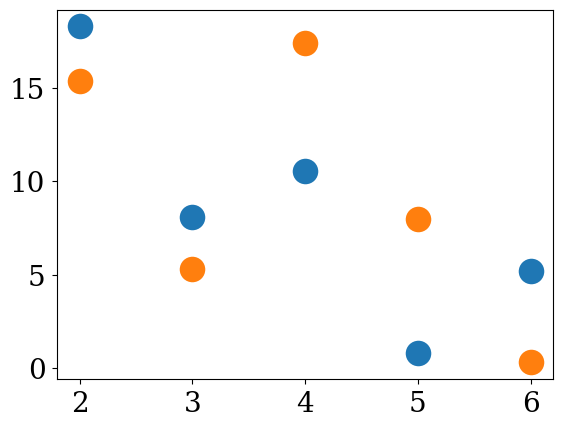

In [128]:
with open("results/N_mnar_nonpositive.pkl", "rb") as f :
    N_mnar_nonpositive = pickle.load(f)

with open("results/N_mcar_nonpositive.pkl", "rb") as f :
    N_mcar_nonpositive = pickle.load(f)

# MCAR + non-positive (just L-shaped) 

N_mcar_nonpositive_CI = np.zeros( (5, 3) )
for i in range(5):
    perf_vec = N_mcar_nonpositive[i]
    center, sd = np.mean(perf_vec), np.std(perf_vec)
    N_mcar_nonpositive_CI[i, :] = np.array( [center, center - 1.96*sd/np.sqrt(30), center + 1.96*sd/np.sqrt(30)] )


N_mnar_nonpositive_CI = np.zeros( (5, 3) )
for i in range(5):
    perf_vec = N_mnar_nonpositive[i]
    center, sd = np.mean(perf_vec), np.std(perf_vec)
    N_mnar_nonpositive_CI[i, :] = np.array( [center, center - 1.96*sd/np.sqrt(30), center + 1.96*sd/np.sqrt(30)] )


x = np.arange(5) + 2

sns.scatterplot(x = x, y = N_mcar_nonpositive_CI[:, 0])
sns.scatterplot(x = x, y = N_mnar_nonpositive_CI[:, 0])

print(N_mnar_nonpositive_CI[:, 0])
print(N_mcar_nonpositive_CI[:, 0])
# sns.kdeplot(N_mnar_nonpositive[0], label = "N = 2^3", shade = True, color = 'red')
# sns.kdeplot(N_mcar_nonpositive[0], label = "N = 2^3", shade = True, color = 'blue')

# sns.kdeplot(N_mnar_nonpositive[0], label = "N = 2^2", shade = True)
# sns.kdeplot(N_mnar_nonpositive[1], label = "N = 2^3", shade = True)
# sns.kdeplot(N_mnar_nonpositive[2], label = "N = 2^4", shade = True)
# sns.kdeplot(N_mnar_nonpositive[3], label = "N = 2^5", shade = True)
# sns.kdeplot(N_mnar_nonpositive[4], label = "N = 2^6", shade = True)

# sns.kdeplot(N_mcar_nonpositive[4], label = "N = 2^3", shade = True, color = 'blue')

In [113]:
missing_pattern = "mcar"

print( "results/rebuttal" + missing_pattern + ".pkl" )
print("results/mcar.pkl")

results/mcar.pkl
results/mcar.pkl
